In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

- [출처](https://yaeyang0629.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%ED%8C%8C%EC%9D%B4%EC%8D%AC-Random-Forest-Regressor%ED%9A%8C%EA%B7%80)

In [2]:
def make_train_df(rating,clothes,user):
    df = pd.merge(rating,user,how='inner',on='R_id')
    df = pd.merge(df,clothes,how='inner',on='image')
    df=df.drop(columns=['스타일선호','mar','job','income','r_style1','r_style2','r_style3','r_style4','r_style5'])
    df_rating = df['선호여부']
    df = df.drop(columns=['선호여부'])
    encoder = OneHotEncoder(sparse_output=False)
    #print(df.head())
    df_encoded = encoder.fit_transform(df.loc[:,'r_gender':'분위기'])
    
    df_encoded = pd.DataFrame(df_encoded,columns= [f"col{i}_{elem}" for i,sublist in enumerate(encoder.categories_) for elem in sublist])
    #df = pd.concat([df[['R_id','image']],df_encoded,df.loc[:,'멋있다':].astype(np.int8)],axis=1)
    df = pd.concat([df_encoded,df.loc[:,'멋있다':]],axis=1)
    #df = df_encoded

    return df,df_rating,encoder

In [3]:
def make_test_df(rating,clothes,user,encoder):
    df = pd.merge(rating,user,how='inner',on='R_id')
    df = pd.merge(df,clothes,how='inner',on='image')
    
    df=df.drop(columns=['스타일선호','mar','job','income','r_style1','r_style2','r_style3','r_style4','r_style5'])
    df_rating = df['선호여부']
    df = df.drop(columns=['선호여부'])
    df_encoded = encoder.transform(df.loc[:,'r_gender':'분위기'])
    df_encoded = pd.DataFrame(df_encoded,columns= [f"col{i}_{elem}" for i,sublist in enumerate(encoder.categories_) for elem in sublist])
    #df = pd.concat([df[['R_id','image']],df_encoded,df.loc[:,'멋있다':].astype(np.int8)],axis=1)
    df = pd.concat([df_encoded,df.loc[:,'멋있다':]],axis=1)
    #df = df_encoded
    return df,df_rating

In [4]:
rating = pd.read_csv('../preprocessed/TL_man_rating_2019.csv')
clothes = pd.read_csv('../preprocessed/TL_man_clothes_2019.csv',index_col='image')
user = pd.read_csv('../preprocessed/TL_man_user_2019.csv',index_col='R_id')

train_x,train_y,encoder = make_train_df(rating,clothes,user)

In [5]:
train_x.to_csv('../train/train_x_man.csv',index=False)
train_y.to_csv('../train/train_y_man.csv',index=False)

In [6]:
with open('../encoder/onehot_encoder_man.pkl','wb') as f:
    pickle.dump(encoder,f)

In [7]:
rating = pd.read_csv('../preprocessed/VL_man_rating_2019.csv')
clothes = pd.read_csv('../preprocessed/VL_man_clothes_2019.csv',index_col='image')
user = pd.read_csv('../preprocessed/VL_man_user_2019.csv',index_col='R_id')


In [8]:
test_x,test_y = make_test_df(rating,clothes,user,encoder)

In [9]:
params = {
    'n_estimators':(100, 200),
    'min_samples_leaf' : (8, 18),
    'min_samples_split' : (8, 16)
}
rf_run = RandomForestRegressor(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_run, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(train_x, train_y)
 
 
print('최적 하이퍼 파라미터:', grid_cv.best_params_)
print('최적 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터: {'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 100}
최적 예측 정확도: 0.2837


In [9]:
reg = RandomForestRegressor(random_state=0,n_jobs=-1)
reg.fit(train_x,train_y)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [10]:
ftr_importances_values = reg.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=train_x.columns)
ftr_top = ftr_importances.sort_values(ascending=False)[:20]

ftr_top

독특하다          0.140425
깔끔하다          0.066280
멋있다           0.033039
col9_적당함      0.027454
실용적이다         0.023579
남성적이다         0.022744
활동적이다         0.022663
무난하다          0.022648
col1_20대      0.022079
편안하다          0.022009
트렌디하다         0.021484
col1_30대      0.020687
도시적이다         0.020671
col1_40대      0.020326
세련되다          0.020313
col8_데이트      0.017743
부드럽다          0.017443
col4_round    0.016739
col7_봄/가을     0.016697
발랄하다          0.016678
dtype: float64

In [11]:
import math
from sklearn.metrics import mean_squared_error
train_predict = reg.predict(train_x)
print("RMSE:{}".format(math.sqrt(mean_squared_error(train_predict, train_y))) )

RMSE:0.3042768214456649


In [12]:
test_predict = reg.predict(test_x)
print("RMSE':{}".format(math.sqrt(mean_squared_error(test_predict, test_y))) )

RMSE':0.759339263537916


In [13]:
from sklearn.metrics import classification_report
def map_to_binary(value):
    if value<3.0:
        return 0
    return 1

train_predict_binary = np.vectorize(map_to_binary)(train_predict)
train_y_binary = np.vectorize(map_to_binary)(train_y)
test_predict_binary = np.vectorize(map_to_binary)(test_predict)
test_y_binary = np.vectorize(map_to_binary)(test_y)


In [14]:
print(classification_report(train_y_binary,train_predict_binary))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79      6883
           1       1.00      0.42      0.59      6224

    accuracy                           0.72     13107
   macro avg       0.83      0.71      0.69     13107
weighted avg       0.82      0.72      0.69     13107



In [15]:
print(classification_report(test_y_binary,test_predict_binary))

              precision    recall  f1-score   support

           0       0.59      0.96      0.73       939
           1       0.86      0.28      0.42       862

    accuracy                           0.63      1801
   macro avg       0.72      0.62      0.58      1801
weighted avg       0.72      0.63      0.58      1801



In [16]:
def precision_at_k(rating_,predict_value,k):
    rating_df = pd.read_csv(rating_)
    predict_df = pd.DataFrame({'예측': predict_value})
    rating_df = pd.concat([rating_df,predict_df],axis=1)

    precisions = []

    for user in rating_df['R_id'].unique():
        if len(rating_df[rating_df['R_id']==user])>=2:
            pred = rating_df.loc[rating_df['R_id'] == user,['image','선호여부','예측']].sort_values(by='예측',ascending=False).reset_index(drop=True)
            pred_k = pred.head(k)
            precision = len(pred_k.loc[pred_k['선호여부']>=3.0]) / float(k)
            precisions.append(precision)
                
    return sum(precisions) / len(precisions)


def recall_at_k(rating_,predict_value,k):
    rating_df = pd.read_csv(rating_)
    
    predict_df = pd.DataFrame({'예측': predict_value})
 
    rating_df = pd.concat([rating_df,predict_df],axis=1)
    recalls = []

  
    for user in rating_df['R_id'].unique():
        if len(rating_df[rating_df['R_id']==user])>=2:
            pred = rating_df.loc[rating_df['R_id']==user,['image','선호여부','예측']].sort_values(by='예측',ascending=False).reset_index(drop=True)
            pred_k = pred.head(k)
            recall = len(pred_k.loc[pred_k['선호여부']>=3.0]) / len(pred.loc[pred['선호여부']>=3]) if len(pred.loc[pred['선호여부']>=3.0])>0 else 0
            recalls.append(recall)

    return sum(recalls) / len(recalls)

In [17]:
#precision@k of train
k=10
print(f"precision@{k} of train" , precision_at_k('../preprocessed/TL_man_rating_2019.csv',train_predict,k))
print(f"recall@{k} of train" , recall_at_k('../preprocessed/TL_man_rating_2019.csv',train_predict,k))

precision@10 of train 0.3352597781669597
recall@10 of train 0.9296015321323622


In [18]:
#validation data에는 아이디당 옷을 1~2개 밖에 평가하지 않음. 따라서 precision는 오류가 있음
print(f"precision@{k} of test: ",precision_at_k('../preprocessed/VL_man_rating_2019.csv',test_predict,k))
print(f"recall@{k} of test: ",recall_at_k('../preprocessed/VL_man_rating_2019.csv',test_predict,k))

precision@10 of test:  0.13402298850574776
recall@10 of test:  0.7724137931034483


In [19]:
pre_train=[0]*11
rec_train=[0]*11
pre_test=[0]*11
rec_test=[0]*11
for i in range(1,12):
    pre_train[i-1] = precision_at_k('../preprocessed/TL_man_rating_2019.csv',train_predict,i)
    rec_train[i-1]=recall_at_k('../preprocessed/TL_man_rating_2019.csv',train_predict,i)
    pre_test[i-1]=precision_at_k('../preprocessed/VL_man_rating_2019.csv',test_predict,i)
    rec_test[i-1]=recall_at_k('../preprocessed/VL_man_rating_2019.csv',test_predict,i)

In [20]:
for i in range(1,12):
    print(f"precision@{i} of train: {pre_train[i-1]}")
    print(f"recall@{i} of train: {rec_train[i-1]}")
    print(f"precision@{i} of test: {pre_test[i-1]}")
    print(f"recall@{i} of test: {rec_test[i-1]}")

precision@1 of train: 0.9416228838295388
recall@1 of train: 0.3827021874077275
precision@1 of test: 0.632183908045977
recall@1 of test: 0.4350957854406131
precision@2 of train: 0.8706946876824285
recall@2 of train: 0.6240831060861276
precision@2 of test: 0.5310344827586206
recall@2 of test: 0.6707662835249042
precision@3 of train: 0.7859505740416416
recall@3 of train: 0.7741177372711342
precision@3 of test: 0.4130268199233722
recall@3 of test: 0.7418773946360154
precision@4 of train: 0.691768826619965
recall@4 of train: 0.855334551389634
precision@4 of test: 0.32471264367816094
recall@4 of test: 0.7604980842911878
precision@5 of train: 0.6024518388791599
recall@5 of train: 0.8951490174507977
precision@5 of test: 0.26712643678161047
recall@5 of test: 0.771647509578544
precision@6 of train: 0.5251021599532977
recall@6 of train: 0.9133639505288899
precision@6 of test: 0.22260536398467468
recall@6 of test: 0.771647509578544
precision@7 of train: 0.4600950713034784
recall@7 of train: 0.9201

In [21]:
import matplotlib.pyplot as plt

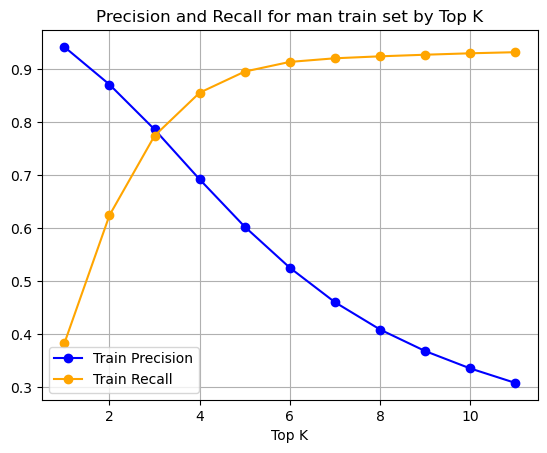

In [22]:

plt.plot(range(1, 12), pre_train, label='Train Precision', color='blue',marker='o')
plt.plot(range(1, 12), rec_train, label='Train Recall', color='orange',marker='o')
plt.title('Precision and Recall for man train set by Top K')
plt.legend()
plt.grid()
plt.xlabel('Top K')
plt.show()

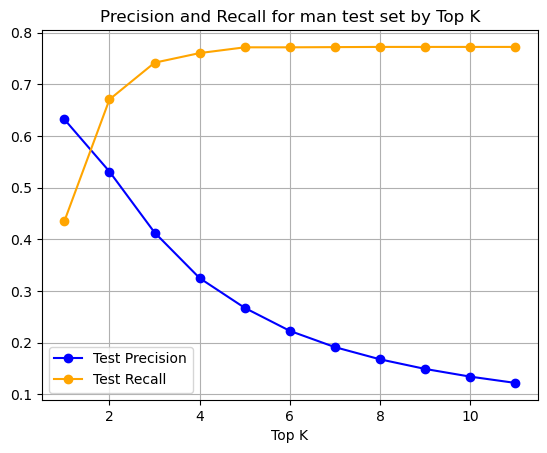

In [23]:
plt.grid()
plt.plot(range(1, 12), pre_test,  label='Test Precision', color='blue', marker='o')
plt.plot(range(1, 12), rec_test,  label='Test Recall', color='orange', marker='o')
plt.title('Precision and Recall for man test set by Top K')
plt.xlabel('Top K')
plt.legend()
plt.show()

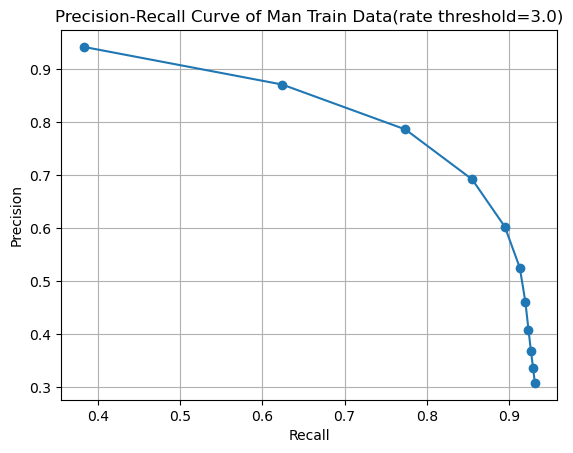

In [24]:
import matplotlib.pyplot as plt

plt.plot(rec_train,pre_train,"o-")
plt.title("Precision-Recall Curve of Man Train Data(rate threshold=3.0)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()


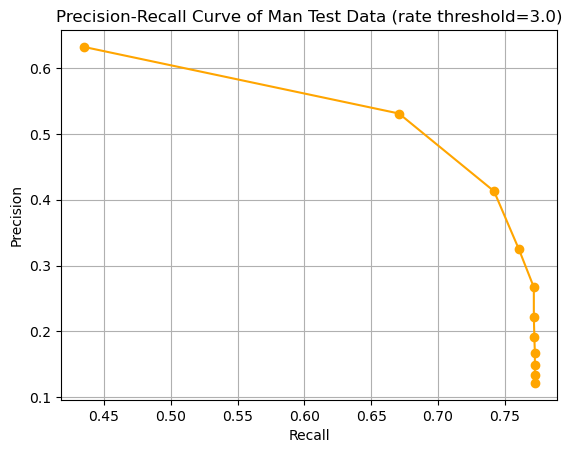

In [25]:
plt.plot(rec_test,pre_test,"o-",color='orange')
plt.title("Precision-Recall Curve of Man Test Data (rate threshold=3.0)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()


In [26]:
def precision_at_k_by_personal(rating_,user_,predict_value,k):
    rating_df = pd.read_csv(rating_)
    user_df = pd.read_csv(user_)
    predict_df = pd.DataFrame({'예측': predict_value})
    rating_df = rating_df.merge(user_df,how='inner',on='R_id')
    rating_df = pd.concat([rating_df,predict_df],axis=1)

    precisions = []

    for color in rating_df['personal_color'].unique():
        for face in rating_df['faceshape'].unique():
            for body in rating_df['bodyshape'].unique():

                pred = rating_df.loc[(rating_df['personal_color']==color) & (rating_df['faceshape']==face) & (rating_df['bodyshape']==body),['image','선호여부','예측']].sort_values(by='예측',ascending=False).reset_index(drop=True)
                pred_k = pred.head(k)
                if len(pred_k)>0:
                    precision = len(pred_k.loc[pred_k['선호여부']>=3.0]) / float(k)
                    precisions.append(precision)

    return sum(precisions) / len(precisions)


def recall_at_k_by_personal(rating_,user_,predict_value,k):
    rating_df = pd.read_csv(rating_)
    user_df = pd.read_csv(user_)
    predict_df = pd.DataFrame({'예측': predict_value})
    rating_df = rating_df.merge(user_df,how='inner',on='R_id')
    rating_df = pd.concat([rating_df,predict_df],axis=1)
    recalls = []

    for color in rating_df['personal_color'].unique():
        for face in rating_df['faceshape'].unique():
            for body in rating_df['bodyshape'].unique():

                pred = rating_df.loc[(rating_df['personal_color']==color) & (rating_df['faceshape']==face) & (rating_df['bodyshape']==body),['image','선호여부','예측']].sort_values(by='예측',ascending=False).reset_index(drop=True)
                pred_k = pred.head(k)
                if len(pred_k)>0:
                    recall = len(pred_k.loc[pred_k['선호여부']>=3.0]) / len(pred.loc[pred['선호여부']>=3.0]) if len(pred.loc[pred['선호여부']>=3.0])>0 else 0
                    recalls.append(recall)

    return sum(recalls) / len(recalls)

In [27]:
k=10
print(f"precision@{k} of train" , precision_at_k_by_personal('../preprocessed/TL_man_rating_2019.csv','../preprocessed/TL_man_user_2019.csv',train_predict,k))
print(f"recall@{k} of train" , recall_at_k_by_personal('../preprocessed/TL_man_rating_2019.csv','../preprocessed/TL_man_user_2019.csv',train_predict,k))

precision@10 of train 0.8763157894736842
recall@10 of train 0.30235557307507


In [28]:
print(f"precision@{k} of test: ",precision_at_k_by_personal('../preprocessed/VL_man_rating_2019.csv','../preprocessed/VL_man_user_2019.csv',test_predict,k))
print(f"recall@{k} of test: ",recall_at_k_by_personal('../preprocessed/VL_man_rating_2019.csv','../preprocessed/VL_man_user_2019.csv',test_predict,k))

precision@10 of test:  0.6212121212121214
recall@10 of test:  0.4631355061262156


In [29]:
pre_train_per=[0]*11
rec_train_per=[0]*11
pre_test_per=[0]*11
rec_test_per=[0]*11
for i in range(1,12):
    pre_train_per[i-1] = precision_at_k_by_personal('../preprocessed/TL_man_rating_2019.csv','../preprocessed/TL_man_user_2019.csv',train_predict,i)
    rec_train_per[i-1]=recall_at_k_by_personal('../preprocessed/TL_man_rating_2019.csv','../preprocessed/TL_man_user_2019.csv',train_predict,i)
    pre_test_per[i-1]=precision_at_k_by_personal('../preprocessed/VL_man_rating_2019.csv','../preprocessed/VL_man_user_2019.csv',test_predict,i)
    rec_test_per[i-1]=recall_at_k_by_personal('../preprocessed/VL_man_rating_2019.csv','../preprocessed/VL_man_user_2019.csv',test_predict,i)

In [30]:
for i in range(1,12):
    print(f"precision@{i} of train: {pre_train_per[i-1]}")
    print(f"recall@{i} of train: {rec_train_per[i-1]}")
    print(f"precision@{i} of test: {pre_test_per[i-1]}")
    print(f"recall@{i} of test: {rec_test_per[i-1]}")

precision@1 of train: 0.9736842105263158
recall@1 of train: 0.07190222397417365
precision@1 of test: 0.8484848484848485
recall@1 of test: 0.10590175163702378
precision@2 of train: 0.9736842105263158
recall@2 of train: 0.1438044479483473
precision@2 of test: 0.7727272727272727
recall@2 of test: 0.1745166613603747
precision@3 of train: 0.9473684210526315
recall@3 of train: 0.17623298771199467
precision@3 of test: 0.7373737373737373
recall@3 of test: 0.21948641863517163
precision@4 of train: 0.9276315789473685
recall@4 of train: 0.19988959765108064
precision@4 of test: 0.7272727272727273
recall@4 of test: 0.2665349320071924
precision@5 of train: 0.9105263157894735
recall@5 of train: 0.2169672602217455
precision@5 of test: 0.7393939393939396
recall@5 of test: 0.3279922391997718
precision@6 of train: 0.8991228070175438
recall@6 of train: 0.23404492279241035
precision@6 of test: 0.712121212121212
recall@6 of test: 0.35930721397729143
precision@7 of train: 0.8909774436090224
recall@7 of train

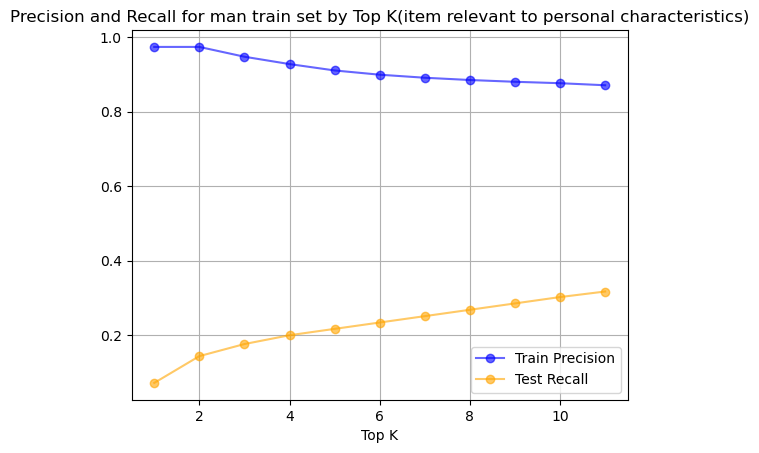

In [36]:

plt.plot(range(1, 12), pre_train_per,  label='Train Precision', color='blue', alpha=0.6,marker='o')
plt.plot(range(1, 12), rec_train_per, label='Test Recall', color='orange', alpha=0.6,marker='o')
plt.grid()
plt.title('Precision and Recall for man train set by Top K(item relevant to personal characteristics)')
plt.legend()
plt.xlabel('Top K')
plt.show()

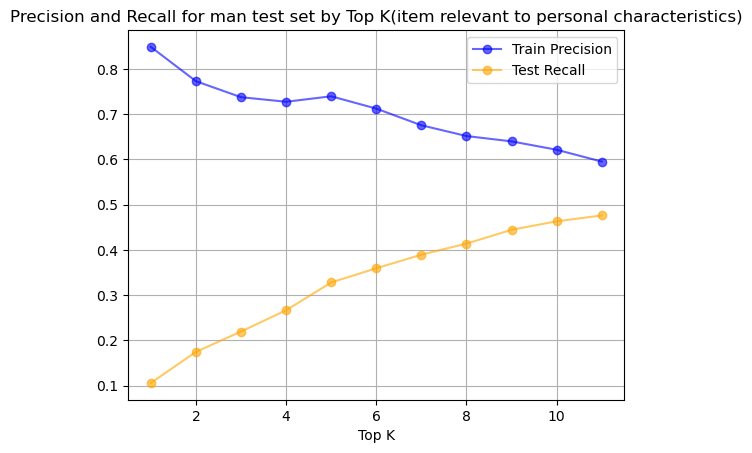

In [37]:

plt.plot(range(1, 12), pre_test_per,  label='Train Precision', color='blue', alpha=0.6,marker='o')
plt.plot(range(1, 12), rec_test_per, label='Test Recall', color='orange', alpha=0.6,marker='o')
plt.grid()
plt.title('Precision and Recall for man test set by Top K(item relevant to personal characteristics)')
plt.legend()
plt.xlabel('Top K')
plt.show()

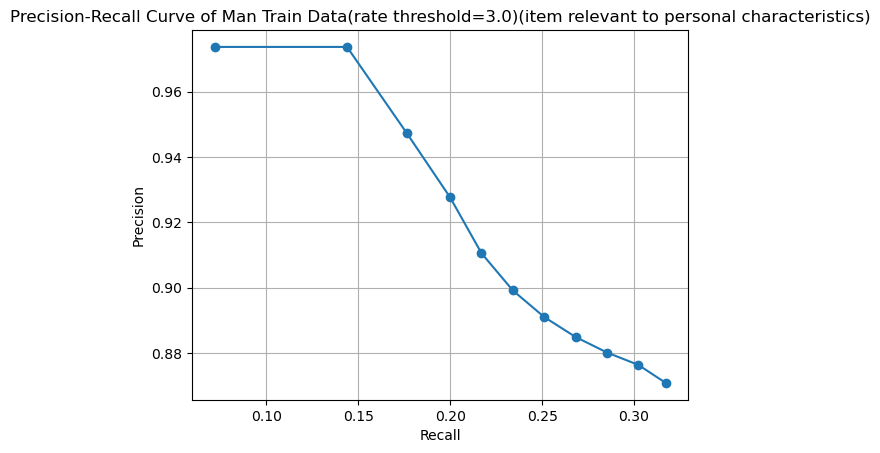

In [38]:
plt.plot(rec_train_per,pre_train_per,"o-")
plt.title("Precision-Recall Curve of Man Train Data(rate threshold=3.0)(item relevant to personal characteristics)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

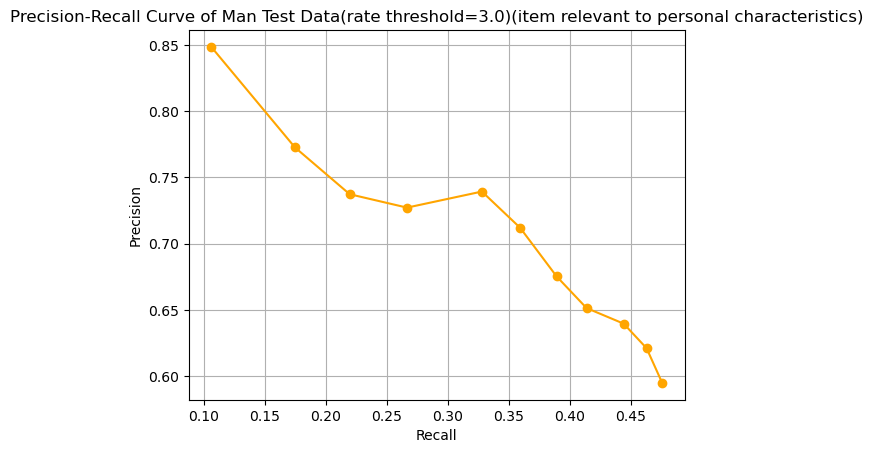

In [39]:
plt.plot(rec_test_per,pre_test_per,"o-",color='orange')
plt.title("Precision-Recall Curve of Man Test Data(rate threshold=3.0)(item relevant to personal characteristics)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

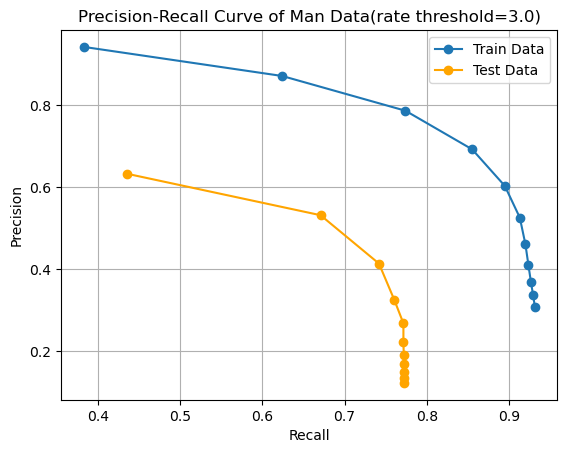

In [40]:
plt.plot(rec_train,pre_train,"o-",label='Train Data')
plt.plot(rec_test,pre_test,"o-",color='orange',label='Test Data')
plt.title("Precision-Recall Curve of Man Data(rate threshold=3.0)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

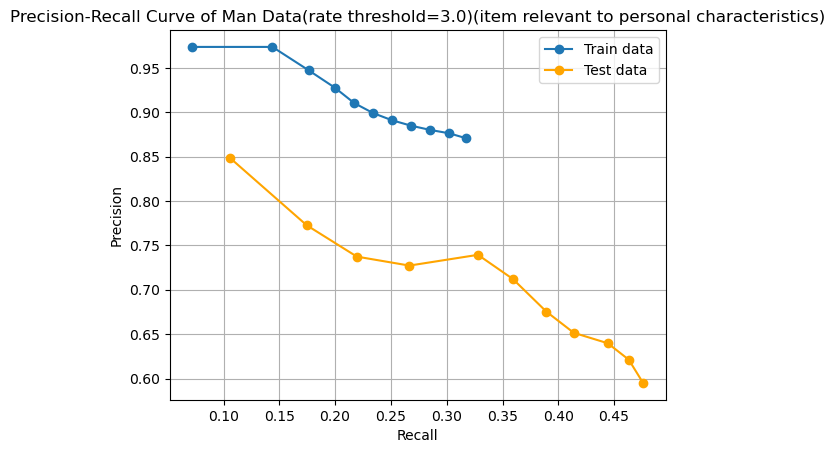

In [41]:
plt.plot(rec_train_per,pre_train_per,"o-",label='Train data')
plt.plot(rec_test_per,pre_test_per,"o-",color='orange',label='Test data')
plt.title("Precision-Recall Curve of Man Data(rate threshold=3.0)(item relevant to personal characteristics)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

In [51]:
#참고
pd.read_csv('../preprocessed/TL_man_rating_2019.csv')['R_id'].value_counts().value_counts()
#training data에는 아이디당 5~7개 옷 평가

count
6     379
7     376
5     290
8     214
4     162
3      69
40     54
10     35
9      35
2      34
11     14
12     12
1      10
25      7
39      5
15      5
23      3
42      2
14      2
22      2
24      2
16      2
13      1
41      1
17      1
18      1
19      1
21      1
33      1
35      1
36      1
Name: count, dtype: int64

In [52]:
#참고
pd.read_csv('../preprocessed/VL_man_rating_2019.csv')['R_id'].value_counts().value_counts()
#validation data에는 아이디당 1~2개 옷 평가

count
1     532
2     239
3      87
5      72
4      31
8       3
6       2
10      1
Name: count, dtype: int64

In [42]:
train_man_rating_count=pd.read_csv('../preprocessed/TL_man_rating_2019.csv')['R_id'].value_counts().value_counts()
test_man_rating_count=pd.read_csv('../preprocessed/VL_man_rating_2019.csv')['R_id'].value_counts().value_counts()

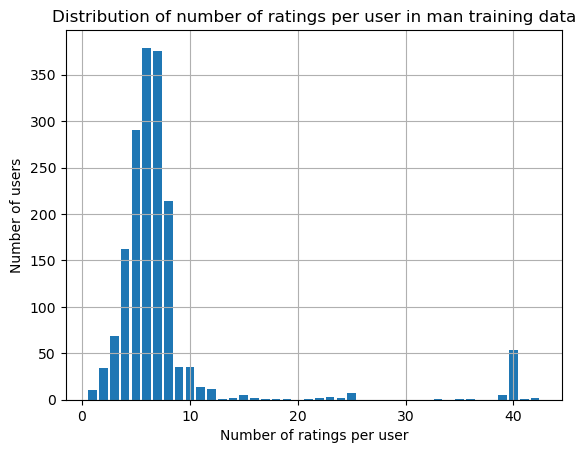

In [49]:
plt.bar(train_man_rating_count.index,train_man_rating_count.values)
plt.xlabel('Number of ratings per user')
plt.ylabel('Number of users')
plt.title('Distribution of number of ratings per user in man training data')
plt.grid()

plt.show()

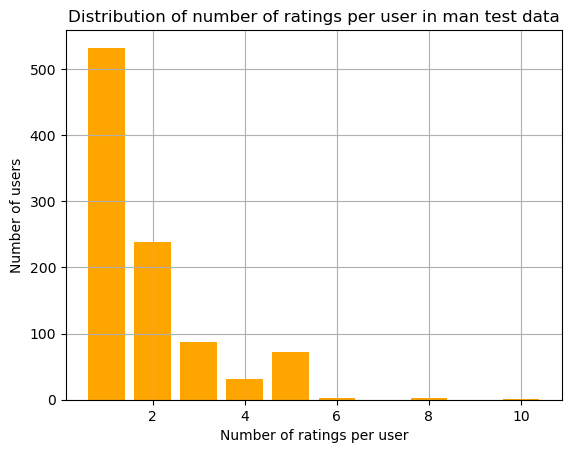

In [50]:
plt.bar(test_man_rating_count.index,test_man_rating_count.values,color='orange')
plt.xlabel('Number of ratings per user')
plt.ylabel('Number of users')
plt.title('Distribution of number of ratings per user in man test data')
plt.grid()

plt.show()

In [53]:
def recommend_internal(clothes_path,encoder_path,gender,age,color,face,body):
    
    df_user=pd.DataFrame.from_dict({'r_gender':[gender],'age':[age],'personal_color':[color],'faceshape':[face],'bodyshape':[body]})
    df_clothes = pd.read_csv(clothes_path)
    df = pd.concat([df_user,df_clothes],axis=1)
    df = df.ffill()
    df_clothes_name = df['image']
    df = df.drop(columns=['image'])

    encoder = ''
    with open(encoder_path,'rb') as f:
        encoder = pickle.load(f)
    df_encoded = encoder.transform(df.loc[:,'r_gender':'분위기'])
    df_encoded = pd.DataFrame(df_encoded,columns= [f"col{i}_{elem}" for i,sublist in enumerate(encoder.categories_) for elem in sublist])
    df_test = pd.concat([df_encoded,df.loc[:,'멋있다':].astype(np.int8)],axis=1)

    predict = reg.predict(df_test)
    rating = pd.DataFrame.from_dict({'rating':predict})
    return pd.concat([df_clothes_name,rating],axis=1).sort_values(by=['rating'], axis=0, ascending=False)

- 퍼스널컬러: spring,summer,autumn,winter
- 얼굴형: 'Heart, Oblong, Oval, Round, Square'
- (남자)체형 : TRAPEZOID,ROUND,RECTANGLE,INVERTED_TRIANGLE,TRIANGLE
- (여자)체형 : HOURGLASS,ROUND,RECTANGLE,INVERTED_TRIANGLE,TRIANGLE

In [54]:
recommend_internal('../preprocessed/TL_man_clothes_2019.csv','../encoder/onehot_encoder_man.pkl','남성','20대','spring','round','round').head(n=10)

,image,rating
10390,W_81578_19_normcore_M.jpg,3.780000
9133,W_63901_19_normcore_M.jpg,3.770000
7824,W_54264_19_normcore_M.jpg,3.760000
1301,T_17451_19_normcore_M.jpg,3.760000
10323,W_81468_19_normcore_M.jpg,3.750000
3921,W_01418_19_normcore_M.jpg,3.743333
2840,T_19532_19_normcore_M.jpg,3.740000
1072,T_17134_19_normcore_M.jpg,3.700000
6970,W_31826_19_normcore_M.jpg,3.700000
1036,T_17087_19_normcore_M.jpg,3.683333


In [55]:
recommend_internal('../preprocessed/TL_man_clothes_2019.csv','../encoder/onehot_encoder_man.pkl','남성','20대','summer','oval','round').head(n=10)

,image,rating
1301,T_17451_19_normcore_M.jpg,3.800000
1047,T_17106_19_normcore_M.jpg,3.790000
1072,T_17134_19_normcore_M.jpg,3.770000
5925,W_25210_19_normcore_M.jpg,3.760000
9133,W_63901_19_normcore_M.jpg,3.750000
4175,W_04320_19_normcore_M.jpg,3.750000
362,T_02130_19_normcore_M.jpg,3.740000
5840,W_24671_19_normcore_M.jpg,3.740000
1036,T_17087_19_normcore_M.jpg,3.733333
7824,W_54264_19_normcore_M.jpg,3.730000


In [56]:
import joblib
joblib.dump(reg, '../model/random_man.pkl') 

['../model/random_man.pkl']